In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
import torch

# To evaluate baseline model
from baseline_train import CLIPReward, ClipRewardEnv

# To evaluate Hybrid model
from train import CLIPReward, HybridRewardEnv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def evaluate_model(model_path, num_episodes=10):

    # Env - Cartpole
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    
    # Reward Model - clip annd hybrid
    clip_reward = CLIPReward(device=device, goal_prompt="pole vertically upright on top of the cart")

    '''# Baseline env
    env = ClipRewardEnv(env, clip_reward)'''

    # Hybrid env
    env = HybridRewardEnv(env, clip_reward)
    model = DQN.load(model_path)

    episode_reward = []
    pole_angles = []  
    step_rewards = []          

    for ep in range(num_episodes):
        obs, info = env.reset()
        done = False
        ep_reward = 0
        ep_angles = []
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            ep_reward += reward
            if "pole_angle" in info:
                angle = info["pole_angle"]
            elif hasattr(env.env.unwrapped, "state"):
                angle = env.env.unwrapped.state[2] 
                info["pole_angle"] = angle
            else:
                angle = None
            if angle is not None:
                ep_angles.append(angle)
                step_rewards.append(reward)
            done = terminated or truncated
        episode_reward.append(ep_reward)
        pole_angles.extend(ep_angles)
        print(f"Episode = {ep+1} | Cumulative Reward = {ep_reward}")

    plt.figure()
    plt.plot(episode_reward, marker='o')
    plt.title("Cumulative Reward vs Episode")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.savefig("episode_rewards.png")

    if pole_angles:
        plt.figure()
        angles_deg = np.degrees(pole_angles)
        plt.plot(angles_deg, marker='.', linestyle='none', alpha=0.5)
        plt.title("Pole Angles vs Timestep")
        plt.xlabel("Timestep")
        plt.ylabel("Pole Angle (degrees)")
        plt.savefig("pole_angles.png")

    if pole_angles and step_rewards:
        plt.figure()
        angles_deg = np.degrees(pole_angles)
        plt.scatter(angles_deg, step_rewards, alpha=0.5)
        plt.title("Pole Angle vs Reward")
        plt.xlabel("Pole Angle (degrees)")
        plt.ylabel("Reward")
        plt.savefig("pole_angle_vs_reward.png")

    plt.show()
    env.close()




Episode = 1 | Cumulative Reward = 100.23354571312666
Episode = 2 | Cumulative Reward = 94.23469472676516
Episode = 3 | Cumulative Reward = 100.22893638163805
Episode = 4 | Cumulative Reward = 109.24123267829418
Episode = 5 | Cumulative Reward = 105.75412105023861
Episode = 6 | Cumulative Reward = 105.2452995032072
Episode = 7 | Cumulative Reward = 105.25097136944532
Episode = 8 | Cumulative Reward = 101.73647583276033
Episode = 9 | Cumulative Reward = 114.73815957456827
Episode = 10 | Cumulative Reward = 94.2497535571456


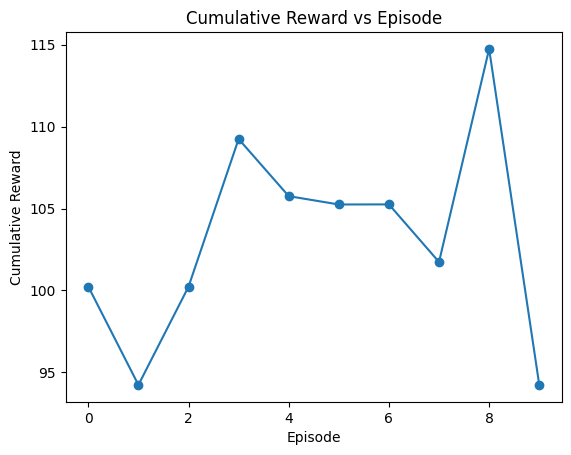

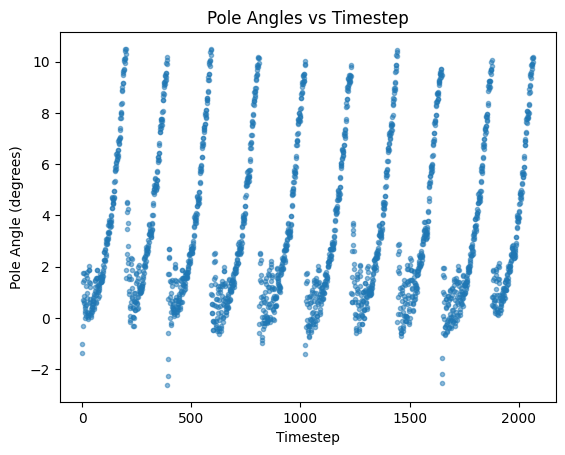

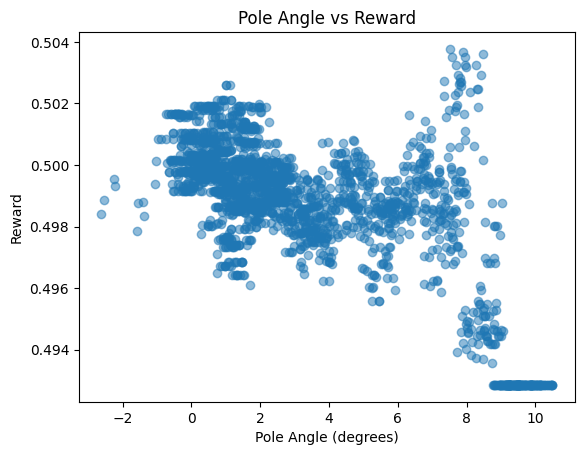

In [10]:
if __name__ == "__main__":
    evaluate_model("/teamspace/studios/this_studio/checkpoints_clip/dqn_cartpole_clip_100000_steps.zip")